In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
from PIL import image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [85]:
!pip install ray

from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 KB 47.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_labels_file = pd.read_csv('/content/drive/My Drive/data/train.csv')
print('train_labels\n', train_labels_file[:3])
#n = 10
#img_name = train_labels_file[n, 0]
#rain_labels = train_labels_file.iloc[n, 1:]

#print('Image name:',img_name)
#print('train labels', train_labelsformat)

train_labels
   Filename  Label
0    1.png      0
1    2.png      0
2    3.png      0


In [76]:
class CellDataset(Dataset):
    """Cell dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cell_records = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.cell_records)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.cell_records.iloc[idx, 0])
        image = io.imread(img_name)
        cell_labels = self.cell_records.iloc[idx, 1:]
        cell_labels = np.array([cell_labels])
        cell_labels = cell_labels.astype('float')
        sample = {'image': image, 'cell_labels': cell_labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (100, 100, 3) [[0.]]


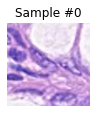

1 (100, 100, 3) [[0.]]


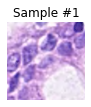

2 (100, 100, 3) [[0.]]


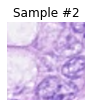

3 (100, 100, 3) [[0.]]


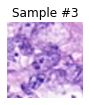

In [77]:
cell_dataset = CellDataset(csv_file='/content/drive/My Drive/data/train.csv',
                                    root_dir='/content/drive/My Drive/data/train')

#print('cell dataset : ', cell_dataset)
#fig = plt.figure()

for i in range(len(cell_dataset)):
    sample = cell_dataset[i]
    #print("Cell Label : ", sample['cell_labels'])  
    print(i, sample['image'].shape, sample['cell_labels'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
    plt.show()

#    show_landmarks(**sample)

    if i == 3:
       break

In [78]:
### Delete this cell afterwards

from torchvision import transforms
convert_tensor = transforms.ToTensor()
for i in range(len(cell_dataset)):
    sample = cell_dataset[i]#

    #print(i, sample['image'].size(), sample['cell_labels'].size())
    #print(sample['image'])
#   print(convert_tensor(sample['cell_labels']))

#    if i == 3:
#        break

tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.]]], dtype=torch.float64)
tensor([[[0.

KeyboardInterrupt: ignored

In [79]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, cell_labels = sample['image'], sample['cell_labels']
        print("type image : ", (cell_labels))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'cell_labels': torch.from_numpy(cell_labels)}

In [80]:
transformed_dataset = CellDataset(csv_file='/content/drive/My Drive/data/train.csv',
                                           root_dir='/content/drive/My Drive/data/train',
                                           transform=transforms.Compose([
                                               #Rescale(256),
                                               #RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['cell_labels'].size())

    if i == 3:
        break

type image :  [[0.]]
0 torch.Size([3, 100, 100]) torch.Size([1, 1])
type image :  [[0.]]
1 torch.Size([3, 100, 100]) torch.Size([1, 1])
type image :  [[0.]]
2 torch.Size([3, 100, 100]) torch.Size([1, 1])
type image :  [[0.]]
3 torch.Size([3, 100, 100]) torch.Size([1, 1])


type image :  [[1.]]
type image :  [[3.]]
type image :  [[1.]]
type image :  [[1.]]
0 torch.Size([4, 3, 100, 100]) torch.Size([4, 1, 1])
type image :  [[1.]]
type image :  [[1.]]
type image :  [[3.]]
type image :  [[1.]]
1 torch.Size([4, 3, 100, 100]) torch.Size([4, 1, 1])
type image :  [[1.]]
type image :  [[1.]]
type image :  [[3.]]
type image :  [[3.]]
2 torch.Size([4, 3, 100, 100]) torch.Size([4, 1, 1])
type image :  [[3.]]
type image :  [[1.]]
type image :  [[3.]]
type image :  [[1.]]
3 torch.Size([4, 3, 100, 100]) torch.Size([4, 1, 1])


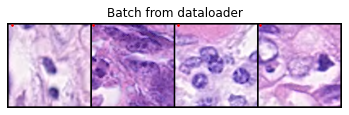

In [84]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_cell_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, cell_labels_batch = \
            sample_batched['image'], sample_batched['cell_labels']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(cell_labels_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    + grid_border_size,s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change "num_workers" to 0. 

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['cell_labels'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_cell_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [86]:
# Neural Network

class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [89]:
def train_network(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(transformed_dataset)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [90]:
#Test accuracy

def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [91]:
#Hyperparameter Tuning 

config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16])
}

In [96]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    #data_dir = os.path.abspath("./data")
    #load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_network, data_dir=cell_dataset),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=3, max_num_epochs=10, gpus_per_trial=0)

2023-03-26 11:13:51,403	INFO worker.py:1553 -- Started a local Ray instance.
/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/function_trainable.py:612: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  warnings.warn(
2023-03-26 11:13:52,641	INFO tensorboardx.py:170 -- pip install "ray[tune]" to see TensorBoard files.
2023-03-26 11:13:52,642	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-03-26 11:13:52 (running for 00:00:00.18)
Memory usage on this node: 2.7/25.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/4 CPUs, 0/1 GPUs, 0.0/15.03 GiB heap, 0.0/7.51 GiB objects
Result logdir: /root/ray_results/train_network_2023-03-26_11-13-52
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+---------------------------+----------+-------------------+--------------+------+------+-------------+
| Trial name                | status   | loc               |   batch_size |   l1 |   l2 |          lr |
|---------------------------+----------+-------------------+--------------+------+------+-------------|
| train_network_4a743_00000 | RUNNING  | 172.28.0.12:48848 |            4 |   16 |   64 | 0.00128094  |
| train_network_4a743_00001 | PENDING  |                   |            8 |    8 |    4 | 0.0828853   |
| train_network_4a743_00002 | PENDING  |           

2023-03-26 11:13:56,421	ERROR trial_runner.py:1062 -- Trial train_network_4a743_00000: Error processing event.
ray.exceptions.RayTaskError(NameError): ray::ImplicitFunc.train() (pid=48848, ip=172.28.0.12, repr=func)
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/trainable.py", line 368, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/function_trainable.py", line 337, in entrypoint
    return self._trainable_func(
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/function_trainable.py", line 654, in _trainable_func
    output = fn()
  File "<ipython-input-89-c9964c3c0526>", line 20, in train_network
NameError: name 'load_data' is not defined


Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
train_network_4a743_00000,2023-03-26_11-13-56,98c0ab0631ac4894a8499602b6de137a,f1963fc59ff5,172.28.0.12,48848,1679829236,4a743_00000
train_network_4a743_00001,2023-03-26_11-13-59,f4b859d92b694d9d8a121bf7f9d585a3,f1963fc59ff5,172.28.0.12,48913,1679829239,4a743_00001
train_network_4a743_00002,2023-03-26_11-14-00,ffaa29223cb44f99b71a79e62f7d61ad,f1963fc59ff5,172.28.0.12,48960,1679829240,4a743_00002


2023-03-26 11:13:59,934	ERROR trial_runner.py:1062 -- Trial train_network_4a743_00001: Error processing event.
ray.exceptions.RayTaskError(NameError): ray::ImplicitFunc.train() (pid=48913, ip=172.28.0.12, repr=func)
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/trainable.py", line 368, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/function_trainable.py", line 337, in entrypoint
    return self._trainable_func(
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/function_trainable.py", line 654, in _trainable_func
    output = fn()
  File "<ipython-input-89-c9964c3c0526>", line 20, in train_network
NameError: name 'load_data' is not defined


== Status ==
Current time: 2023-03-26 11:13:59 (running for 00:00:07.29)
Memory usage on this node: 3.0/25.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/4 CPUs, 0/1 GPUs, 0.0/15.03 GiB heap, 0.0/7.51 GiB objects
Result logdir: /root/ray_results/train_network_2023-03-26_11-13-52
Number of trials: 3/3 (2 ERROR, 1 RUNNING)
+---------------------------+----------+-------------------+--------------+------+------+-------------+
| Trial name                | status   | loc               |   batch_size |   l1 |   l2 |          lr |
|---------------------------+----------+-------------------+--------------+------+------+-------------|
| train_network_4a743_00002 | RUNNING  | 172.28.0.12:48960 |            4 |   64 |   32 | 0.000429259 |
| train_network_4a743_00000 | ERROR    | 172.28.0.12:48848 |            4 |   16 |   64 | 0.00128094  |
| train_network_4a743_00001 | ERROR    | 172.28.0.12:

2023-03-26 11:14:00,904	ERROR trial_runner.py:1062 -- Trial train_network_4a743_00002: Error processing event.
ray.exceptions.RayTaskError(NameError): ray::ImplicitFunc.train() (pid=48960, ip=172.28.0.12, repr=func)
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/trainable.py", line 368, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/function_trainable.py", line 337, in entrypoint
    return self._trainable_func(
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/trainable/function_trainable.py", line 654, in _trainable_func
    output = fn()
  File "<ipython-input-89-c9964c3c0526>", line 20, in train_network
NameError: name 'load_data' is not defined


== Status ==
Current time: 2023-03-26 11:14:00 (running for 00:00:08.26)
Memory usage on this node: 2.8/25.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/15.03 GiB heap, 0.0/7.51 GiB objects
Result logdir: /root/ray_results/train_network_2023-03-26_11-13-52
Number of trials: 3/3 (3 ERROR)
+---------------------------+----------+-------------------+--------------+------+------+-------------+
| Trial name                | status   | loc               |   batch_size |   l1 |   l2 |          lr |
|---------------------------+----------+-------------------+--------------+------+------+-------------|
| train_network_4a743_00000 | ERROR    | 172.28.0.12:48848 |            4 |   16 |   64 | 0.00128094  |
| train_network_4a743_00001 | ERROR    | 172.28.0.12:48913 |            8 |    8 |    4 | 0.0828853   |
| train_network_4a743_00002 | ERROR    | 172.28.0.12:48960 |      

TuneError: ignored